In [63]:
import os
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# 任务一: 生成train/test.txt

## A. 画出人脸边框以及相应关键点

In [126]:
root = os.getcwd()
root

'C:\\Users\\Thinkpad X1 Carbon\\Desktop\\Deep-Learning-CV-master\\Project03_Face_Keypoints_Detection'

In [125]:
data_root = root + "\\data"
datasets = ['I', 'II']
# for dataset in datasets:   
#     names = os.listdir(data_root + "\\" + dataset)
#     # filename = [data_root + "/" + dataset + "/" + name for name in names if ".txt" not in name]
#     file= open("filename_{}.txt".format(dataset), 'w')
#     for name in names:
#         if ".txt" not in name:    
#             file.write(data_root + "/" + dataset + "/" + name + '\n')
#     file.close()

C:\Users\Thinkpad X1 Carbon\Desktop\Deep-Learning-CV-master\Project03_Face_Keypoints_Detection


### 1. 首先画一下第一张图片的边框和关键点

In [95]:
path = data_root + "\\" + "I"
filepath = path + "\\" + "label.txt"
file = np.loadtxt(filepath, dtype=np.str)
info = file[0]
# print(info)
img_path = path + "\\" + info[0]
img = Image.open(img_path)

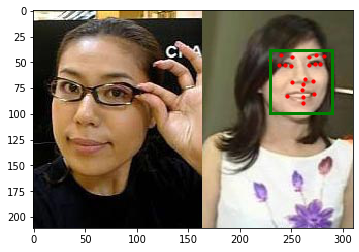

In [112]:
bbox = info[1:5].astype(np.float32)
x1, y1 = bbox[0:2]  # 左上角
x2, y2 = bbox[2:4]  # 右下角
keypoints = info[5:47].astype(np.float32).reshape(21, 2)

plt.imshow(img)
plt.gca().add_patch(  # 获取当前子图plt.gca(): Get Current Axes
    plt.Rectangle(xy=(x1, y1), width=x2-x1, height=y2-y1,
                 fill=False, edgecolor='g', linewidth=3))
for x, y in keypoints:
    plt.gca().scatter(x, y, c='r', s=10)

### 2.整理成函数

In [108]:
def draw(img_path, info):
    img = Image.open(img_path)
    img_name = info[0]
    print(img_name)
    bbox = info[1:5].astype(np.float32)
    x1, y1 = bbox[0:2]  # 左上角
    x2, y2 = bbox[2:4]  # 右下角
    keypoints = info[5:47].astype(np.float32).reshape(21, 2)
    plt.figure()
    plt.imshow(img)
    plt.title(img_name)
    plt.gca().add_patch(  # 获取当前子图plt.gca(): Get Current Axes
        plt.Rectangle(xy=(x1, y1), width=x2 - x1, height=y2 - y1,
                      fill=False, edgecolor='g', linewidth=3))
    for x, y in keypoints:
        plt.gca().scatter(x, y, c='r', s=10)
    plt.show()


def random_draw(root, dataset, seed=None):
    data_root = root + "\\data"
    dataset = dataset
    path = data_root + "\\" + dataset
    file = np.loadtxt(path + "\\" + "label.txt", dtype=np.str)
    seed = seed
    if seed is not None:
        np.random.seed(seed)
    while True:
        idx = np.random.randint(0, len(file) - 1)
        info = file[idx]
        img_path = path + "\\" + info[0]
        draw(img_path, info)
        yield

In [109]:
RD = random_draw(root, "I")

**运行`next(RD)`, 每次随机绘图**:

002914.jpg


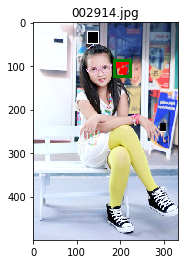

In [110]:
next(RD)

004237.jpg


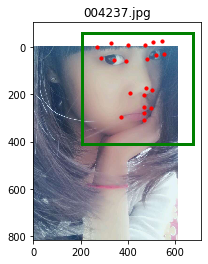

In [131]:
next(RD)

005783.jpg


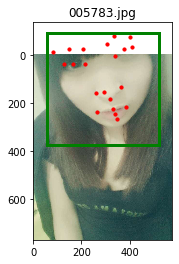

In [134]:
next(RD)

## B. 适当扩大人脸边框的范围, 获取expand后的人脸边框坐标

## C. 用expanded人脸边框截取人脸, 获取截取后的人脸关键点坐标

## D. 按比例生成训练与测试数据, 获取train.txt和test.txt

## E. 对生成的数据进行验证